In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
sys.path.insert(0, "/so/home/jsugiyama/git/sotodlib/")
import sotodlib
from sotodlib.tod_ops import fft_ops, detrend_tod
from sotodlib import core
from sotodlib import hwp
from sotodlib.io import load_smurf as ls
from sotodlib.io.load_smurf import Observations, Files, TuneSets, Tunes
from sotodlib.io import g3tsmurf_utils
import datetime

In [86]:
start = datetime.datetime.now()
ctx_file = '/so/metadata/satp3/contexts/use_this.yaml'
ctx = core.Context(ctx_file)
obs_id = 'obs_1709601492_satp3_1111111'
ws = 'ws0'
bandpass = 'f150'
debug = 1000
meta = ctx.get_meta(obs_id, dets={'wafer_slot': ws, 'wafer.bandpass': bandpass})
meta.restrict('dets', meta.dets.vals[:debug])
aman = ctx.get_obs(meta)
for idet in range(aman.dets.count) : 
    aman.signal[idet] *= aman.det_cal.phase_to_pW[idet]
alive = np.where(np.any(np.isnan(aman.signal), axis=1)==False)
aman.restrict('dets', aman.dets.vals[alive])
detrend_tod(aman)
signal=aman.signal
freqs, pxx = fft_ops.calc_psd(
            aman, signal=signal, timestamps=aman.timestamps, max_samples=2**20, merge=True, nperseg=len(aman.timestamps)
        )
stop = datetime.datetime.now()
print(stop - start)

0:00:58.033336


In [28]:
aman

AxisManager(timestamps[samps], ancil*[samps], boresight*[samps], signal[dets,samps], biases[bias_lines,samps], primary*[samps], iir_params*, flags*[dets,samps], obs_info*, det_cal*[dets], pointing_model*, focal_plane*[dets], hwp_angle_model*, hwp_solution*[samps], abscal*[dets], det_info*[dets], freqs[nusamps], Pxx[dets,nusamps], dets:LabelAxis(661), samps:OffsetAxis(741367), bias_lines:LabelAxis(12), nusamps:OffsetAxis(370684))

# New features

* PSD mask
    * Masking HWPSS or vibration signals makes the fitting stable
* PSD binning
    * Fitting becomes about 25 times faster than without binning
    * Knee frequency and white noise level are unbiased
    * The standard errors of the fit parameters become smaller
* Other changes in the fitting functions
    * Fitting parameters can be reduced (white noise or alpha can be fixed)
    * Minimum frequency for the fit can be decrared
    * IndexError Exception is added to the Hessian calculation. IndexError occurs when the 1/f fit fails in the case where, for example, the signal is nan.

# "calc_psd_mask"

``calc_psd_mask`` returns Ranges array to mask hwpss or single peak in the given PSD.\
If mode == "replace", it will return new mask in aman.PSD_mask.\
If mode == "add", new mask range will be added to the existing aman.PSD_mask.
You can obtain masked PSD like:\
"""\
mask = ~aman.PSD_mask.mask()\
f = f[mask]\
pxx = pxx[:, mask]\
"""

0:00:00.126438


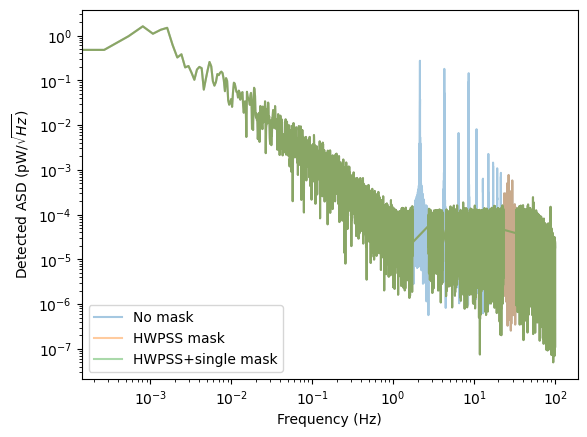

In [66]:
start = datetime.datetime.now()
plt.figure()
plt.loglog(aman.freqs, np.sqrt(aman.Pxx[0]), alpha=0.4, label="No mask")
# create hwpss mask
fft_ops.get_psd_mask(aman, mask_hwpss=True, hwpss_width=((-0.4, 0.6),(-0.2, 0.2)), merge=True)
mask = ~aman.psd_mask.mask()
plt.loglog(aman.freqs[mask], np.sqrt(aman.Pxx[0][mask]), alpha=0.4, label="HWPSS mask")

# add single peak mask
fft_ops.get_psd_mask(aman, psd_mask=aman.psd_mask.mask(),mask_peak=True, peak_freq=28, peak_width=(-5, +5), merge=True)
mask = ~aman.psd_mask.mask()
plt.loglog(aman.freqs[mask], np.sqrt(aman.Pxx[0][mask]), alpha=0.4, label="HWPSS+single mask")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Detected ASD (pW/$\sqrt{Hz}$)')
plt.legend()
stop = datetime.datetime.now()
print(stop - start)

# "fit_noise_model"

New feature of fit_noise_model is that
* Fit PSD with masks if ``mask``==True and PSD_mask in aman,
* Parameters of white noise or alpha can be fixed to the initially estimated value. For example, we experimentally know that fixing alpha is good for fitting demodulated signals.
* ``fft_ops.calc_wn`` returns 
* ``f_min`` has been added to limit the minimum frequency to fit.

In [64]:
wn_initial_val = fft_ops.calc_wn(aman, pxx=aman.Pxx, freqs=aman.freqs, low_f=5, high_f=10)

In [65]:
start = datetime.datetime.now()
noise_fit_stats_fixed_wn = fft_ops.fit_noise_model(aman, 
                                                   f=aman.freqs, 
                                                   pxx=aman.Pxx, 
                                                   f_min=0.001, 
                                                   f_max=20, 
                                                   mask=True,
                                                   wn_est=wn_initial_val,
                                                   fixed_param="wn")
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)


0:02:27.706427


In [32]:
start = datetime.datetime.now()
noise_fit_stats_fixed_alpha = fft_ops.fit_noise_model(aman, 
                                                      f=aman.freqs, 
                                                      pxx=aman.Pxx, 
                                                      f_min=0.001, 
                                                      f_max=20, 
                                                      mask=True, 
                                                      fknee_est=1,
                                                      wn_est=4E-5,
                                                      alpha_est=3.4,
                                                      fixed_param="alpha")
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib

0:02:29.637383


In [33]:
start = datetime.datetime.now()
noise_fit_stats_all_params = fft_ops.fit_noise_model(aman, 
                                                     f=aman.freqs, 
                                                     pxx=aman.Pxx, 
                                                     f_min=0.001, 
                                                     f_max=20,
                                                     fknee_est=1,
                                                     wn_est=wn,
                                                     alpha_est=3.2,
                                                     mask=True)
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib

0:05:14.785386


/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: divide by zero encountered in divide
  return wn**2 * (1 + (fknee / f) ** alpha)


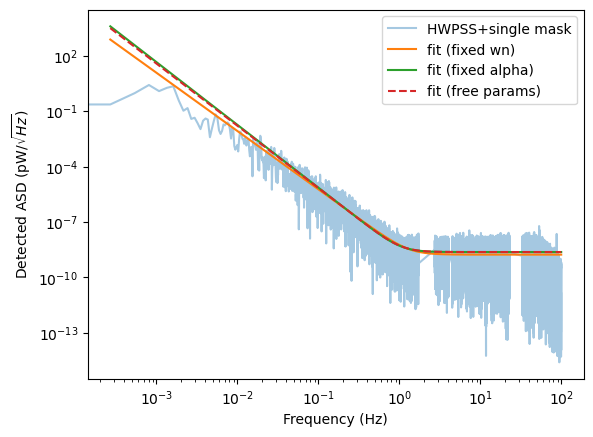

In [67]:
plt.figure()
plt.loglog(aman.freqs[mask], aman.Pxx[0][mask], alpha=0.4, label="HWPSS+single mask")

noise_fit_stats = noise_fit_stats_fixed_wn
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]), label="fit (fixed wn)")

noise_fit_stats = noise_fit_stats_fixed_alpha
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]), label="fit (fixed alpha)")

noise_fit_stats = noise_fit_stats_all_params
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]),"--",  label="fit (free params)")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Detected ASD (pW/$\sqrt{Hz}$)')
plt.legend()

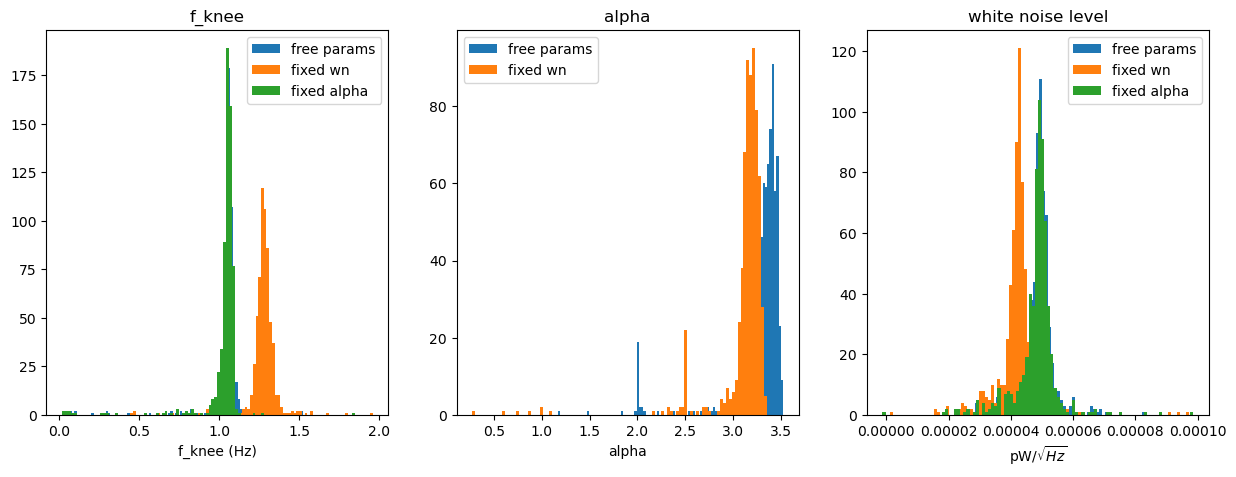

In [74]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee")
noise_fit_stats = noise_fit_stats_all_params
f_knee = noise_fit_stats.fit.T[1]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_fixed_wn
f_knee = noise_fit_stats.fit.T[1]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="fixed wn")
noise_fit_stats = noise_fit_stats_fixed_alpha
f_knee = noise_fit_stats.fit.T[1]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="fixed alpha")
ax1.set_xlabel('f_knee (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha")
noise_fit_stats = noise_fit_stats_all_params
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_fixed_wn
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="fixed wn")

ax2.set_xlabel('alpha')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise level")
noise_fit_stats = noise_fit_stats_all_params
wn = noise_fit_stats.fit.T[0]
ax3.hist(wn[wn<0.0001], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_fixed_wn
wn = noise_fit_stats.fit.T[0]
ax3.hist(wn[wn<0.0001], bins=100, label="fixed wn")
noise_fit_stats = noise_fit_stats_fixed_alpha
wn = noise_fit_stats.fit.T[0]
ax3.hist(wn[wn<0.0001], bins=100, label="fixed alpha")

ax3.set_xlabel('pW/$\sqrt{Hz}$')
ax3.legend()

# "get_binned_psd"

``get_binned_psd`` returns the binned PSD. This function is incorporated to ``fit_noise_model``.\
The parameters ``unbinned_mode`` and ``base`` changes the number of first un-binned modes and binning width, respectively.\
If the number of data points in a bin is less than ``limit_N``, that bin is handled with
chi2 distribution and its error is \<psd>. Otherwise the central limit theorem
is applied to the bin and the error is estimated as  std(psd)/sqrt(len(psd)).

In [37]:
start = datetime.datetime.now()
mask = ~aman.psd_mask.mask()
f = aman.freqs[mask]
pxx = aman.Pxx[:, mask]
f_binned, pxx_binned, bin_size = fft_ops.get_binned_psd(aman, f=f, pxx=pxx, unbinned_mode=3, base=1.2, merge=False)
stop = datetime.datetime.now()
print(stop - start)

0:00:02.277896


(0.0001, 50)

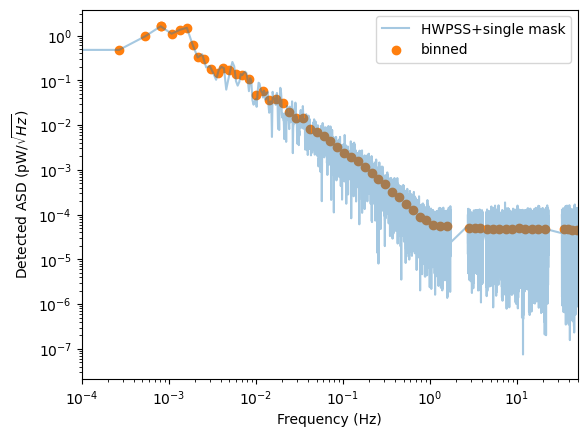

In [68]:
plt.loglog(aman.freqs[mask], np.sqrt(aman.Pxx[0][mask]), alpha=0.4, label="HWPSS+single mask")
plt.scatter(f_binned, np.sqrt(pxx_binned[0]), c='tab:orange', label="binned")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Detected ASD (pW/$\sqrt{Hz}$)')
plt.xlim(1E-4, 50)

You can quickly utilize binning when binning=True is assigned in fit_noise_model.\
The calculation time cost becomes much smaller.

In [69]:
start = datetime.datetime.now()
noise_fit_stats_bin = fft_ops.fit_noise_model(aman, 
                                              f=aman.freqs, 
                                              pxx=aman.Pxx, 
                                              f_min=0.001, 
                                              f_max=20, 
                                              fknee_est=1,
                                              wn_est=4E-5,
                                              alpha_est=3.4,
                                              mask=True, 
                                              binning=True,
                                              unbinned_mode=1, base=1.2)
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)


0:00:08.772663


## Example of the fastest fit operation

Get binned PSD --> estimate white noise --> fit PSD will be the fastest but will have larger fit error.\
Just do binning without parameter fix, which is calculated in the former cell, is the second fastest and returns same result as unbinned procedure.

In [87]:
start = datetime.datetime.now()

# get mask and binned PSD
fft_ops.get_psd_mask(aman, mask_hwpss=True, hwpss_width=((-0.4, 0.6),(-0.2, 0.2)), merge=True)
mask = ~aman.psd_mask.mask()
f = aman.freqs[mask]
pxx = aman.Pxx[:, mask]
f_binned, pxx_binned, bin_size = fft_ops.get_binned_psd(aman, f=f, pxx=pxx, unbinned_mode=3, base=1.05, merge=True)

# calculate white noise value
wn_initial_val = fft_ops.calc_wn(aman, freqs=aman.freqs_bin, pxx=aman.Pxx_bin, low_f=5, high_f=10)

# fit
noise_fit_stats_bin_fixed_wn = fft_ops.fit_noise_model(aman, 
                                              f=aman.freqs_bin, 
                                              pxx=aman.Pxx_bin, 
                                              f_min=0.001, 
                                              f_max=20, 
                                              fknee_est=1,
                                              wn_est=wn_initial_val,
                                              alpha_est=3.4,
                                              fixed_param="wn")
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: invalid value encountered in power
  return wn**2 * (1 + (fknee / f) ** alpha)


0:00:06.645676


### comparison of fit results

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:405: RuntimeWarning: divide by zero encountered in divide
  return wn**2 * (1 + (fknee / f) ** alpha)


(0.0001, 50)

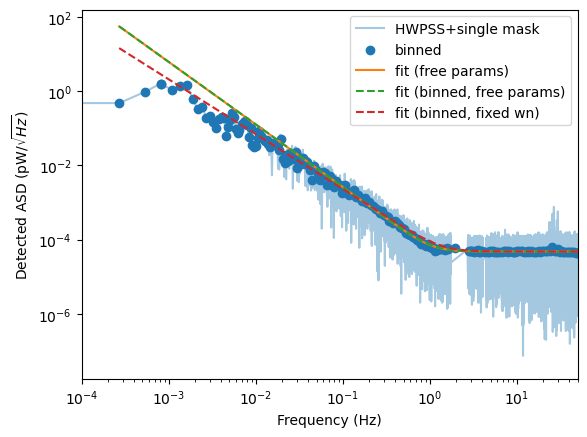

In [88]:
plt.loglog(aman.freqs[mask], np.sqrt(aman.Pxx[0][mask]), alpha=0.4, label="HWPSS+single mask", zorder=0)
plt.scatter(f_binned, np.sqrt(pxx_binned[0]), label="binned", zorder=1)
noise_fit_stats = noise_fit_stats_all_params
plt.loglog(aman.freqs, np.sqrt(fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0])),  label="fit (free params)")
noise_fit_stats = noise_fit_stats_bin
plt.loglog(aman.freqs, np.sqrt(fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0])), label="fit (binned, free params)", ls="--")
noise_fit_stats = noise_fit_stats_bin_fixed_wn
plt.loglog(aman.freqs, np.sqrt(fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0])), label="fit (binned, fixed wn)", ls="--")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Detected ASD (pW/$\sqrt{Hz}$)')
plt.xlim(1E-4, 50)

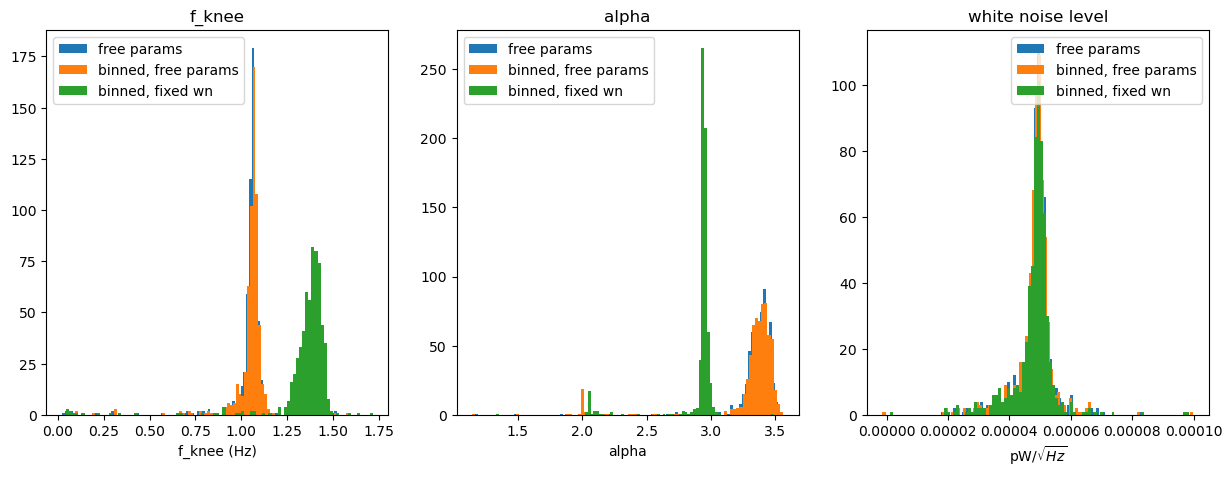

In [89]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee")
noise_fit_stats = noise_fit_stats_all_params
f_knee = noise_fit_stats.fit.T[1]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
f_knee = noise_fit_stats.fit.T[1]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="binned, free params")
noise_fit_stats = noise_fit_stats_bin_fixed_wn
f_knee = noise_fit_stats.fit.T[1]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="binned, fixed wn")

ax1.set_xlabel('f_knee (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha")
noise_fit_stats = noise_fit_stats_all_params
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="binned, free params")
noise_fit_stats = noise_fit_stats_bin_fixed_wn
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="binned, fixed wn")

ax2.set_xlabel('alpha')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise level")
noise_fit_stats = noise_fit_stats_all_params
wn = noise_fit_stats.fit.T[0]
ax3.hist(wn[wn<0.0001], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
wn = noise_fit_stats.fit.T[0]
ax3.hist(wn[wn<0.0001], bins=100, label="binned, free params")
noise_fit_stats = noise_fit_stats_bin_fixed_wn
wn = noise_fit_stats.fit.T[0]
ax3.hist(wn[wn<0.0001], bins=100, label="binned, fixed wn")
ax3.set_xlabel('pW/$\sqrt{Hz}$')
ax3.legend()

### comparison of fit parameters std errors between binned and not binned

/tmp/ipykernel_98715/2886714995.py:15: RuntimeWarning: invalid value encountered in sqrt
  f_knee.append(np.sqrt(noise_fit_stats.cov[i][1][1]))


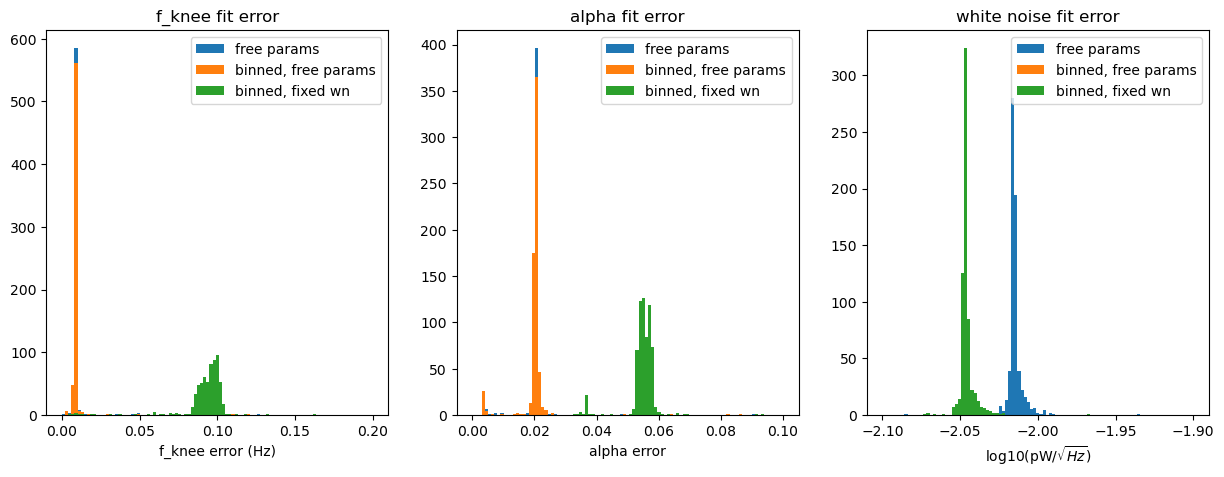

In [93]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee fit error")
f_knee = []
alpha = []
wn = []
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    f_knee.append(np.sqrt(noise_fit_stats.cov[i][1][1]))
f_knee=np.array(f_knee)
ax1.hist(f_knee, bins=np.linspace(0, 0.2, 100), label="free params")
noise_fit_stats = noise_fit_stats_bin
f_knee = []
for i in range(aman.dets.count):
    f_knee.append(np.sqrt(noise_fit_stats.cov[i][1][1]))
f_knee=np.array(f_knee)
ax1.hist(f_knee, bins=np.linspace(0, 0.2, 100), label="binned, free params")
noise_fit_stats = noise_fit_stats_bin_fixed_wn
f_knee = []
for i in range(aman.dets.count):
    f_knee.append(np.sqrt(noise_fit_stats.cov[i][1][1]))
f_knee=np.array(f_knee)
ax1.hist(f_knee, bins=np.linspace(0, 0.2, 100), label="binned, fixed wn")
ax1.set_xlabel('f_knee error (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha fit error")
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    alpha.append(np.sqrt(noise_fit_stats.cov[i][2][2]))
alpha=np.array(alpha)
ax2.hist(alpha, bins=np.linspace(0, 0.1, 100), label="free params")
noise_fit_stats = noise_fit_stats_bin
alpha = []
for i in range(aman.dets.count):
    alpha.append(np.sqrt(noise_fit_stats.cov[i][2][2]))
alpha=np.array(alpha)
ax2.hist(alpha, bins=np.linspace(0, 0.1, 100), label="binned, free params")
noise_fit_stats = noise_fit_stats_bin_fixed_wn
alpha = []
for i in range(aman.dets.count):
    alpha.append(np.sqrt(noise_fit_stats.cov[i][2][2]))
alpha=np.array(alpha)
ax2.hist(alpha, bins=np.linspace(0, 0.1, 100), label="binned, fixed wn")
ax2.set_xlabel('alpha error')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise fit error")
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    wn.append(np.sqrt(np.abs(noise_fit_stats.cov[i][0][0])))
ax3.hist(np.log10(wn), bins=np.linspace(-2.1, -1.9, 100), label="free params")
wn = []
noise_fit_stats = noise_fit_stats_bin
for i in range(aman.dets.count):
    wn.append(np.sqrt(np.abs(noise_fit_stats.cov[i][0][0])))
ax3.hist(np.log10(wn), bins=np.linspace(-2.1, -1.9, 100), label="binned, free params")
noise_fit_stats = noise_fit_stats_bin_fixed_wn
for i in range(aman.dets.count):
    wn.append(np.sqrt(np.abs(noise_fit_stats.cov[i][0][0])))
ax3.hist(np.log10(wn), bins=np.linspace(-2.1, -1.9, 100), label="binned, fixed wn")
#ax3.set_xlim(1E-8,1E-1)
#ax3.set_xscale('log')
ax3.set_xlabel('log10(pW/$\sqrt{Hz}$)')
ax3.legend()